# PPCA in PyStan - Part 1: Setting up the Stan model

In this notebook, we try to perform a PPCA in Pystan.

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check
from utils import loadStan

Here, the model is defined in Stan. Note that $z$ is explicitly specified to have independent dimensions, [as suggested by Svensson](http://www.nxn.se/valent/2016/12/28/pca-with-batch-effects-in-stan)!

In [12]:
ppca_pystan = loadStan('ppca_without_mu')

Model loaded succesfully from cache.


We specify our parameters and generate some data.

In [4]:
N=10000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

And then we can optimize our parameters and latent dataset.

In [16]:
op = ppca_pystan.optimizing(data=ppca_dat)

z_sim = op['z']
sigma_sim = op['sigma']
W_sim = op['W']
x_sim = np.random.normal(np.matmul(W_sim,z_sim),sigma_sim)

Let's compare our models with the real values and the values as found by Tipping & Bishops PPCA method.

In [17]:
ppca = PPCA()
ppca.fit(x.T, mu = np.zeros(D)[np.newaxis].T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]
x_ppca = np.matmul(W,z)
# ppca_em = PPCA()
# ppca_em.fit(x, form='em', em_calc_loglikelihood=False)
# _, sigma_ppca_em, W_ppca_em = ppca.parameters()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [18]:
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance: ', sigma_sim**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real z: ', z)
print('PPCA z: ', z_ppca)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()

real variance:  4.492440400938537
PPCA variance:  4.632448659928819
simulated variance:  1.544187967093168

real z:  [[-0.53688819 -0.81930225 -0.82022352 ...  0.8862376   0.43588794
   0.33155624]
 [ 0.59245791  1.50300459 -0.48578495 ...  0.68036228  0.69298527
   0.77376518]]
PPCA z:  [[ 0.36759393  0.30869743  0.45528467 ... -0.87648972 -0.98871549
   0.56780298]
 [-1.19488516 -1.40527411  4.83710112 ...  3.11790107  1.24965081
  -4.52366473]]
simulated z:  [[ 0.00050267 -0.00077375 -0.00524938 ...  0.00254873  0.00517914
   0.00099812]
 [ 0.00367686  0.00130352 -0.0023638  ... -0.00339636 -0.00106983
   0.00539823]]

real W:  [[ 1.92832978 -1.95479205]
 [ 0.68678608 -0.49471706]
 [ 0.12997318 -1.27508284]]
PPCA W:  [[-2.78089009 -0.23922369]
 [-1.05521834  0.15433181]
 [-0.73551314  0.68306195]]
simulated W:  [[ 4.66537588e+02 -2.96993893e+02]
 [ 1.83084042e+02  1.71095838e-01]
 [-2.86203756e+01 -4.82242714e+02]]



Since $W$ can be rotated, we will compare the shapes of $W$ with the estimate of $W$ and the PPCA solution.

In [19]:
print('Original W and Simulated W:')
rotation_check(W,W_sim, verbose=True)
rotation_check(W,W_sim, verbose=True, method='angles')
print()
print('Original W and PPCA W:')
rotation_check(W,W_ppca, verbose=True)
rotation_check(W,W_ppca, verbose=True, method='angles')
print()
print('PPCA W and simulated W:')
rotation_check(W_ppca,W_sim, verbose=True)
rotation_check(W_ppca,W_sim, verbose=True, method='angles')

Original W and Simulated W:
These might not be rotations. det(R)= 107151.52819510791 R.T*R=
 [[ 91189.96558506 100153.67368179]
 [100153.67368179 235905.43332796]]
These matrices differ in magnitude on row 2 as they are of length 0.716 and 33519.796 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 1.643 and 233377.161 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 7.540 and 305862.693 (0.000x).
These matrices differ at least on the angle between axis 0 and 1 as they are 0.168 and 0.568.
These matrices differ at least on the angle between axis 0 and 2 as they are 0.677 and 1.063.
These matrices differ at least on the angle between axis 1 and 2 as they are 0.845 and 1.631.

Original W and PPCA W:
These might not be rotations. det(R)= 0.8472018451787365 R.T*R=
 [[1.22159549 0.38036471]
 [0.38036471 0.70598515]]
These matrices differ in magnitude on row 2 as they are of length 0.716 and 1.008 (0.711x).
These matrices differ in magnitu

False

It looks like the PPCA solutions are identical (as expected), but not entirely equal to the real solution. The PyStan solution differs even more from the original $W$. One consistent difference is that the values of the simulated $W$ are significantly larger.

The result is plotted below. Similarly to what happened in TensorFlow Probability, the observed data $x$ is predicted accurately, but the latent data $z$ has smaller values, in accordance with the higher values of the solution for $W$. The value for $\sigma$ is also off.

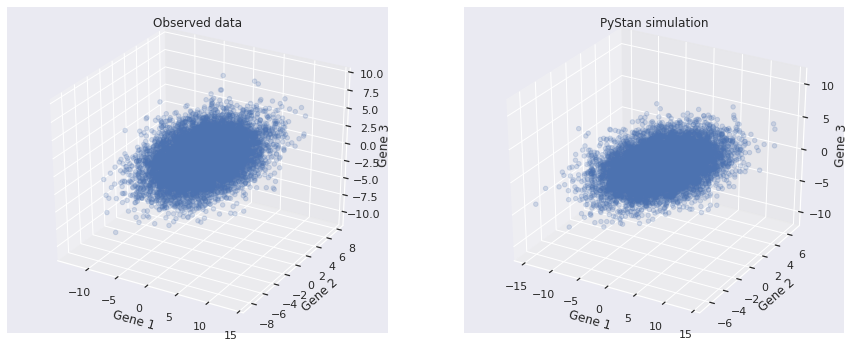

In [20]:
sns.set()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x_sim[0,:],x_sim[1,:],x_sim[2,:], alpha=0.2)
ax.set_title('PyStan simulation')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

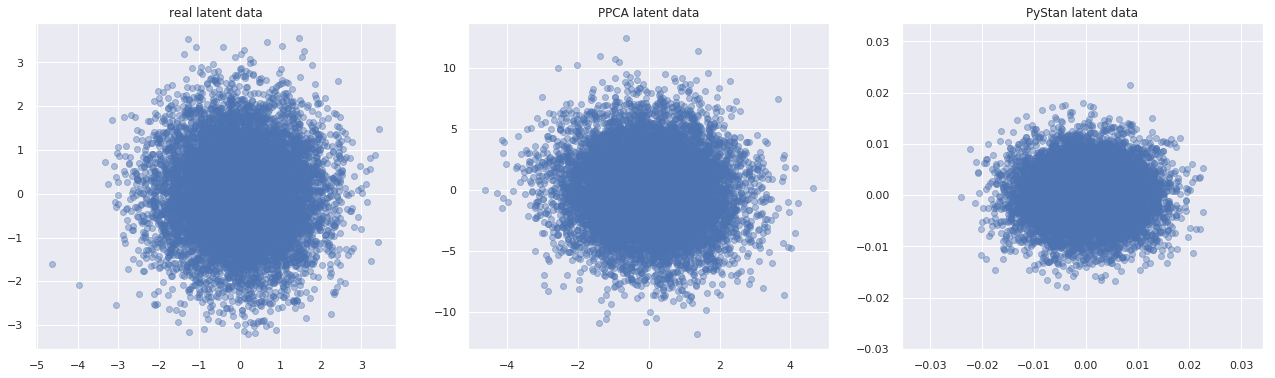

In [21]:
sns.set()
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_sim[0,:], z_sim[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

We can also try to add a $\mu$ to the $x$ values:

In [11]:
ppca_pystan_mu = loadStan('ppca')

Model loaded succesfully from cache.


In [15]:
N=10000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
mu = np.random.normal(0,15,size=(D,1))
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

In [16]:
op = ppca_pystan_mu.optimizing(data=ppca_dat)

z_sim = op['z']
sigma_sim = op['sigma']
W_sim = op['W']
mu_sim = op['mu']
x_sim = np.random.normal(np.matmul(W_sim,z_sim)+mu_sim[np.newaxis].T,sigma_sim)

In [17]:
ppca = PPCA()
ppca.fit(x.T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x-mu_ppca)[0]
x_ppca = np.matmul(W,z)
# ppca_em = PPCA()
# ppca_em.fit(x, form='em', em_calc_loglikelihood=False)
# mu_ppca_em, sigma_ppca_em, W_ppca_em = ppca.parameters()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [18]:
print('real mu: ', mu)
print('PPCA mu: ', mu_ppca)
# print('PPCA mu (em): ', mu_ppca_em)
print('simulated mu: ', mu_sim)
print()
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)
print('simulated variance: ', sigma_sim*2)
print()
print('real z: ', z)
print('PPCA z: ', z_ppca)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()

real mu:  [[ -0.72962821]
 [-11.73197281]
 [-17.83440536]]
PPCA mu:  [[ -0.78504493]
 [-11.79461741]
 [-17.91637439]]
simulated mu:  [10.74697785  2.5573929   5.31078548]

real variance:  5.820878224374418
PPCA variance:  5.796045927965945
simulated variance:  2.8233270676421496

real z:  [[ 1.11794578  1.08266332  0.18137188 ... -0.4325696  -0.22929105
  -0.35988553]
 [-0.92340531 -0.59281413 -1.05383717 ...  0.44391604  0.87985286
   0.03735439]]
PPCA z:  [[  0.16266085   0.12256495   0.68242237 ...   0.03622724   0.0927354
   -0.07776121]
 [ -3.54782972   7.43241798 -10.45690744 ...   4.61177538  16.74357599
   20.10210246]]
simulated z:  [[-0.00458968 -0.00640868 -0.00466747 ... -0.00657282 -0.00730679
  -0.00777953]
 [ 0.00281281  0.00522113  0.00405747 ...  0.00549931  0.00620623
   0.00656716]]

real W:  [[ 1.75892421 -2.5911098 ]
 [ 2.0170975  -2.2093623 ]
 [ 4.26077978 -4.64351122]]
PPCA W:  [[ 3.14965047  0.17599476]
 [ 6.98137353 -0.12099514]
 [-0.74510872 -0.38972873]]
simu

In [19]:
print('Original W and Simulated W:')
rotation_check(W,W_sim, verbose=True)
rotation_check(W,W_sim, verbose=True, method='angles')
print()
print('Original W and PPCA W:')
rotation_check(W,W_ppca, verbose=True)
rotation_check(W,W_ppca, verbose=True, method='angles')
print()
print('PPCA W and simulated W:')
rotation_check(W_ppca,W_sim, verbose=True)
rotation_check(W_ppca,W_sim, verbose=True, method='angles')

Original W and Simulated W:
These might not be rotations. det(R)= 2099205.3430492454 R.T*R=
 [[ 7440640.79486855  8452494.50786567]
 [ 8452494.50786567 10194192.75421774]]
These matrices differ in magnitude on row 2 as they are of length 8.950 and 3128473.949 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 9.808 and 12007108.599 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 39.716 and 92847744.022 (0.000x).
These matrices differ at least on the angle between axis 0 and 1 as they are 0.003 and 0.052.
These matrices differ at least on the angle between axis 0 and 2 as they are 0.144 and 1.836.
These matrices differ at least on the angle between axis 1 and 2 as they are 0.146 and 1.888.

Original W and PPCA W:
These might not be rotations. det(R)= -0.5412463153319623 R.T*R=
 [[24.32988789  3.84101564]
 [ 3.84101564  0.61843066]]
These matrices differ in magnitude on row 2 as they are of length 8.950 and 0.707 (12.658x).
These matri

False

The result is plotted below. We see that $\mu$ is estimated well, but the other parameters are still off, even though the end result of $x$ looks good.

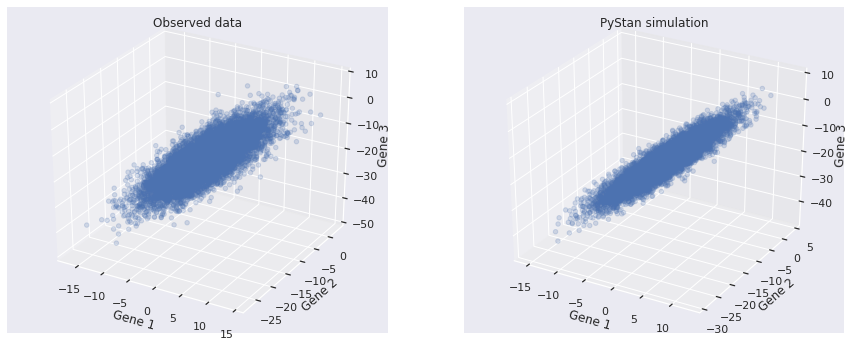

In [20]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x_sim[0,:],x_sim[1,:],x_sim[2,:], alpha=0.2)
ax.set_title('PyStan simulation')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

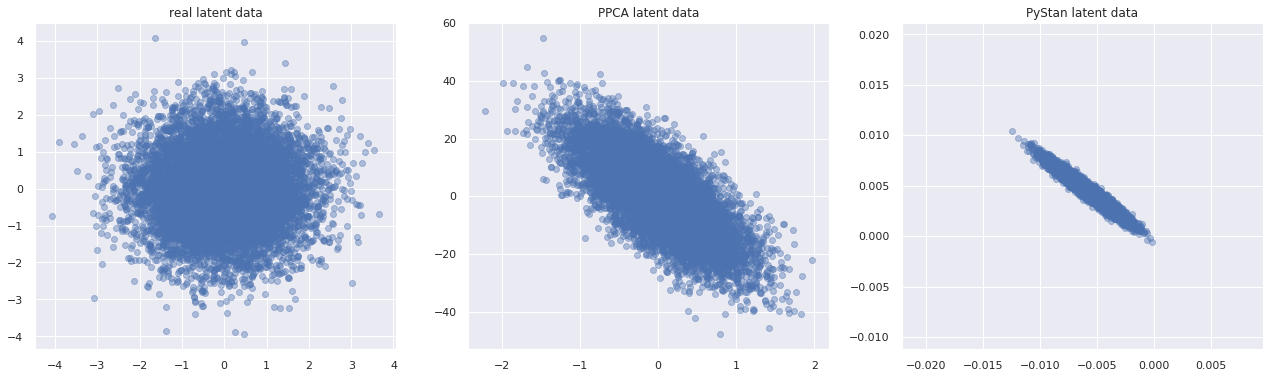

In [21]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_sim[0,:], z_sim[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

## Generating Samples with PyStan

The following section tries to actually generate samples from our distribution. To be honest, PyStan does not lend itself for this feature. I have not found *any* examples of people generating data with PyStan. It is however possible to generate samples from the parameters that are optimized according to the distribution of their posterior probability. The following piece of code treats the output $x$ as a parameter which allows us to sample $x$. It is not a very elegant way to produce samples of the output variable. Besides that, PyStan will try to produce thousands of samples by default - meaning thousands of $\sigma^2$'s, accompanied by a thousand datapoints in $z$ and $x$ for *each* $\sigma^2$ (leading to millions of datapoints). It is possible to write a PyStan model that only outputs $1$ datapoint per run to reduce the number of datapoints, but this will draw a new value for $\sigma^2$ for each datapoint. It is also possible - as performed here in the cells below - to explicitly ask for only one sample of our data ($1$ $\sigma^2$ and $W$, but $1000$ datapoints in $z$ and $x$). Still, this will cause PyStan to generate a lot more samples so that the generating Markov chain has reached a stationary distribution, which is very inefficient computationally.

In [20]:
latent_sampling = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[N,D] x;//  observations
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

transformed parameters{
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    //  priors
    sigma~lognormal(0.0, 1.0) ;
    for (d in 1:D)
        W[d] ~ normal(0.0,sigma);
    
    //  likelihood
    for (n in 1:N){
        x[n] ~ normal(W*col(z,n), sigma);
        z[:,n] ~ multi_normal(mean_z,cov_z);
        }
}
"""
ppca_sampling = pystan.StanModel(model_code=latent_sampling)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07f0256a61c07190db137f50319d640b NOW.


In [21]:
N=1000
M=2
D=3

samples = ppca_sampling.sampling(data={'N':N,'D':D,'M':M}, iter=100, warmup=99, chains=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/usr/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


In [22]:
samples.extract()

OrderedDict([('z',
              array([[[-0.30736752, -0.36061101, -0.49768858, ...,  1.00318658,
                       -0.46191559,  0.4950442 ],
                      [-0.82623919, -0.53520915, -0.72253281, ...,  1.62185241,
                       -0.95643483, -0.38484171]]])),
             ('x', array([[[-0.3324997 ,  0.10999593,  0.38652104],
                      [ 1.90520643, -0.82490268,  0.8272359 ],
                      [ 0.49272984, -1.07831629,  0.43839743],
                      ...,
                      [-1.8115472 ,  1.40095496, -0.4995778 ],
                      [-0.86141537, -1.16440274, -0.34215789],
                      [ 0.79743576,  0.03446065,  1.31011766]]])),
             ('W', array([[[-0.57298497, -0.31265051],
                      [-0.51304225,  1.59459456],
                      [ 0.01050606, -0.48281958]]])),
             ('sigma', array([0.97494097])),
             ('lp__', array([-2493.71118788]))])